In [1]:
from torchvision import datasets, transforms
import torch

dataset_train_t = datasets.CIFAR10('.', train = True, download = False, transform = transforms.ToTensor())
dataset_val_t = datasets.CIFAR10('.', train = False, download = False, transform = transforms.ToTensor())

imgs = torch.stack([img_t for img_t,_ in dataset_train_t], dim=3)
[m1,m2,m3] = imgs.view(3,-1).mean(dim=1).numpy()
[s1,s2,s3] = imgs.view(3,-1).std(dim=1).numpy()
dataset_train_transformed = datasets.CIFAR10('.', train = True, download = False,
                                            transform = transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((m1,m2,m3), (s1,s2,s3))
                                            ]))
dataset_val_transformed = datasets.CIFAR10('.', train = False, download = False,
                                            transform = transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((m1,m2,m3), (s1,s2,s3))
                                            ]))

label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
dataset_train = [(img, label_map[label]) for (img, label) in dataset_train_transformed if label in [0,2]]
dataset_val = [(img, label_map[label]) for (img, label) in dataset_val_transformed if label in [0,2]]
print(len(dataset_train), len(dataset_val))

10000 2000


In [2]:
import torch.nn as nn
conv= nn.Conv2d(3, 16, kernel_size = 3) # 3 input channels (RGB), 16 output channels, 3*3 kernel size, 1*1 stride
print(conv.weight.shape, conv.bias.shape) # bias of conv is the same size as output channels, one bias value per output channel

torch.Size([16, 3, 3, 3]) torch.Size([16])


torch.Size([3, 32, 32]) torch.Size([1, 16, 30, 30])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([30, 30])


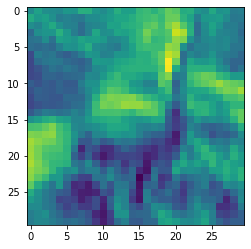

In [3]:
img_t, lbl = dataset_train[0]
out = conv(img_t.unsqueeze(0)) #conv works on B*C*H*W dimensions so image must be extended on 0th dim
print(img_t.shape, out.shape)

from matplotlib import pyplot as plt
plt.imshow(img_t.permute(1,2,0))
plt.imshow(out[0,0].detach().numpy()) #try out[0,0], out[0,1] ... out[0,15]
print(out[0,0].shape) # 30 * 30 in 0th output channel, no padding reduces the size

torch.Size([1, 16, 32, 32])


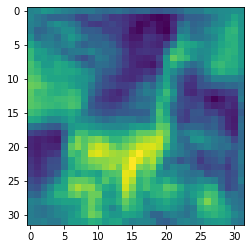

In [4]:
conv = nn.Conv2d(3, 16, kernel_size = 3, padding = 1) #add 1 pixel to the border of images
out = conv(img_t.unsqueeze(0))
print(out.shape)
plt.imshow(out[0,0].detach())

In [5]:
#downsampling
pool = nn.MaxPool2d(2) #2*2 max pooling
print(pool(img_t).shape)

torch.Size([3, 16, 16])


In [6]:
#input: 1 * 3 * 32 * 32
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1), #output: 1 * 16 * 32 * 32
                     nn.Tanh(), #output: 1 * 16 * 32 * 32
                     nn.MaxPool2d(2), #output: 1 * 16 * 16 * 16
                     nn.Conv2d(16, 8, kernel_size=3, padding=1), #output: 1 * 8 * 16 * 16
                     nn.Tanh(), #output: 1 * 8 * 16 * 16
                     nn.MaxPool2d(2), #output: 1 * 8 * 8 * 8
                     nn.Flatten(), # output: 1 * 512
                     nn.Linear(8*8*8, 32), #output: 1 * 32
                     nn.Tanh(), #output: 1 * 32
                     nn.Linear(32,2) # output: 1 * 2
                     )
print([p.numel() for p in model.parameters()]) #1st Conv2d: 16*3*3*3 weights, 16 biases
                                               #2nd Conv2: 8*16*3*3 weights, 8 biases
                                               #1st Linear: 8*8*8*32 weights, 32 biases
                                               #2nd Linear: 32*2 wieghts, 2 biases 
model(img_t.unsqueeze(0))

[432, 16, 1152, 8, 16384, 32, 64, 2]


tensor([[-0.0715, -0.0536]], grad_fn=<AddmmBackward>)

In [7]:
#a nn.Module subclass with user-defined functionalities
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(512, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32,2)
    
    def forward(self,x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out.view(-1, 8*8*8) # does the flattening: 1 * 512
        out = self.fc2(self.act3(self.fc1(out)))
        return out

model = Net()
[p.numel() for p in model.parameters()]

[432, 16, 1152, 8, 16384, 32, 64, 2]

In [8]:
#nn.Tanh() and nn.MaxPool2d do not have parameters to be trained. 
#Using functional to define them as functions in the submodule

import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(512,32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh((self.conv1(x))), 2)
        out = F.max_pool2d(torch.tanh((self.conv2(out))), 2)
        out = out.view(-1, 8*8*8)
        out = self.fc2(torch.tanh(self.fc1(out)))
        return out

model = Net()
print([p.numel() for p in model.parameters()])

model(img_t.unsqueeze(0))
#img_t.unsqueeze(0).shape

[432, 16, 1152, 8, 16384, 32, 64, 2]


tensor([[-0.1187, -0.2929]], grad_fn=<AddmmBackward>)

In [9]:
import datetime

def training_loop(n_epochs, model, loss_fn, optimizer, train_loader):
    for epoch in range(1 + n_epochs):
        train_loss = 0.0
        for (imgs, lbls) in train_loader:
            outs = model(imgs) 
            loss = loss_fn(outs, lbls)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        if epoch%10 == 0:
            print('{} Epoch {}, train loss {}'.format(
                datetime.datetime.now(), epoch, train_loss/len(train_loader)))
    

In [10]:
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=64, shuffle=False)

model = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

training_loop(n_epochs = 100,
              model = model,
              loss_fn = loss_fn,
              optimizer = optimizer,
              train_loader = train_loader)

2022-04-04 19:08:58.504900 Epoch 0, train loss 0.5903032304375035
2022-04-04 19:09:19.703363 Epoch 10, train loss 0.33278256929983757
2022-04-04 19:09:40.917561 Epoch 20, train loss 0.280005200748231
2022-04-04 19:10:02.079043 Epoch 30, train loss 0.2561660957089655
2022-04-04 19:10:23.354073 Epoch 40, train loss 0.23959908008005967
2022-04-04 19:10:44.552544 Epoch 50, train loss 0.2246609479188919
2022-04-04 19:11:05.907265 Epoch 60, train loss 0.21028359163149146
2022-04-04 19:11:27.454657 Epoch 70, train loss 0.19633876437404355
2022-04-04 19:11:48.702621 Epoch 80, train loss 0.18269393213425472
2022-04-04 19:12:10.046013 Epoch 90, train loss 0.16901339846811478
2022-04-04 19:12:31.198781 Epoch 100, train loss 0.1552509972529047


In [11]:
def validate(model, train_loader, val_loader):
    for (name, loader) in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for (imgs, lbls) in loader:
                outs = model(imgs)
                _, predicted = torch.max(outs, dim=1) #index of max is used, not the max probability
                total += lbls.shape[0] # number of examples is accumulated
                correct += int((predicted == lbls).sum())
        print("accuracy {}: {}".format(name, correct/total))

validate(model, train_loader, val_loader)

accuracy train: 0.9294
accuracy val: 0.899


In [12]:
torch.save(model.state_dict(), './birds_airplanes_model.pt') #only parameters are saved, not the network structure itself

In [13]:
load_model = Net()
load_model.load_state_dict(torch.load('./birds_airplanes_model.pt'))

<All keys matched successfully>

In [14]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(dev)

def training_loop(n_epochs, model, loss_fn, optimizer, train_loader):
    for epoch in range(1 + n_epochs):
        train_loss = 0.0
        for (imgs, lbls) in train_loader:
            imgs = imgs.to(device = dev) # move images to dev (cpu or cuda)
            lbls = lbls.to(device = dev) # move labels to dev (cpu or cuda)
            outs = model(imgs) 
            loss = loss_fn(outs, lbls)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        if epoch%10 == 0:
            print('{} Epoch {}, train loss {}'.format(
                datetime.datetime.now(), epoch, train_loss/len(train_loader)))

model = Net().to(device = dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

training_loop(n_epochs = 100,
              model = model,
              loss_fn = loss_fn,
              optimizer = optimizer,
              train_loader = train_loader)

cpu
2022-04-04 19:13:21.041762 Epoch 0, train loss 0.5824354575697783
2022-04-04 19:13:42.068858 Epoch 10, train loss 0.32963660701065306
2022-04-04 19:14:03.256260 Epoch 20, train loss 0.29404123696931606
2022-04-04 19:14:24.402660 Epoch 30, train loss 0.26820156633094616
2022-04-04 19:14:45.468565 Epoch 40, train loss 0.24787293554870946
2022-04-04 19:15:06.707774 Epoch 50, train loss 0.2301603423277284
2022-04-04 19:15:27.932138 Epoch 60, train loss 0.21359395591696356
2022-04-04 19:15:49.069910 Epoch 70, train loss 0.1973653700511167
2022-04-04 19:16:10.179883 Epoch 80, train loss 0.18152965787964262
2022-04-04 19:16:31.679216 Epoch 90, train loss 0.16600072353034262
2022-04-04 19:16:53.589395 Epoch 100, train loss 0.1508954973642234


In [20]:
class NetWidth(nn.Module):
    def __init__(self, n_chann = 32):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_chann, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(n_chann, n_chann // 2, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(8*8*n_chann//2,32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh((self.conv1(x))), 2)
        out = F.max_pool2d(torch.tanh((self.conv2(out))), 2)
        out = out.view(-1, 8*8*n_chann // 2)
        out = self.fc2(torch.tanh(self.fc1(out)))
        return out
model = NetWidth(16)
[p.numel() for p in model.parameters()]

[432, 16, 1152, 8, 16384, 32, 64, 2]

In [23]:
#L2 regularization: scaled sum of square of all weights and added to loss
def training_loop_l2reg(n_epochs, loss_fn, model, optimizer, train_loader):
    for epoch in range(n_epochs + 1):
        loss_train = 0.0
        for imgs, lbls in train_loader:
            imgs = imgs.to(device = dev)
            lbls = lbls.to(device = dev)
            
            outs = model(imgs)
            loss = loss_fn(outs, lbls)
            
            l2_lambda = 0.0001  #scale
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss += l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch%10 == 0:
            print('{} Epoch {}, train loss {}'.format(
                datetime.datetime.now(), epoch, loss_train/len(train_loader)))

model = Net().to(device = dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

training_loop_l2reg(n_epochs = 100,
              model = model,
              loss_fn = loss_fn,
              optimizer = optimizer,
              train_loader = train_loader)

2022-04-05 14:09:12.409421 Epoch 0, train loss 0.5805089671141023
2022-04-05 14:09:35.028305 Epoch 10, train loss 0.32748325966346037
2022-04-05 14:09:58.404968 Epoch 20, train loss 0.2917436910852505
2022-04-05 14:10:21.394728 Epoch 30, train loss 0.26867887263844725
2022-04-05 14:10:44.360163 Epoch 40, train loss 0.25078140161219675
2022-04-05 14:11:07.509703 Epoch 50, train loss 0.23527293827882997
2022-04-05 14:11:30.188294 Epoch 60, train loss 0.22101993882542204
2022-04-05 14:11:52.883772 Epoch 70, train loss 0.20760665644126333
2022-04-05 14:12:15.666325 Epoch 80, train loss 0.19445801383940278
2022-04-05 14:12:39.558623 Epoch 90, train loss 0.18103404518715135
2022-04-05 14:13:02.886291 Epoch 100, train loss 0.16763439323681933


In [27]:
#Dropout: randomly zero out part of outputs in each iteration across nn
class NetDropout(nn.Module):
    def __init__(self, n_chann = 32):
        super().__init__()
        self.n_chann = n_chann
        self.conv1 = nn.Conv2d(3, n_chann, kernel_size = 3, padding = 1)
        self.conv1_dropout = nn.Dropout2d(p = 0.4) # zero each output with probability 0.4
        self.conv2 = nn.Conv2d(n_chann, n_chann // 2, kernel_size = 3, padding = 1)
        self.conv2_dropout = nn.Dropout2d(p = 0.4)
        self.fc1 = nn.Linear(8*8*n_chann//2, 32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8*8*self.n_chann//2)
        out = self.fc2(torch.tanh(self.fc1(out)))
        return out

model = NetDropout(16).to(device = dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

training_loop(n_epochs = 100,
              model = model,
              loss_fn = loss_fn,
              optimizer = optimizer,
              train_loader = train_loader)

2022-04-05 14:34:49.384369 Epoch 0, train loss 0.6061132817890993
2022-04-05 14:35:12.893912 Epoch 10, train loss 0.43156824370098723
2022-04-05 14:35:38.898515 Epoch 20, train loss 0.3860600823239916
2022-04-05 14:36:03.027098 Epoch 30, train loss 0.3711202098115994
2022-04-05 14:36:25.973815 Epoch 40, train loss 0.3539815061031633
2022-04-05 14:36:48.845791 Epoch 50, train loss 0.34695935875746853
2022-04-05 14:37:11.915151 Epoch 60, train loss 0.33926434008179196
2022-04-05 14:37:34.768879 Epoch 70, train loss 0.3253439414273402
2022-04-05 14:37:57.604947 Epoch 80, train loss 0.32017058475761656
2022-04-05 14:38:20.486793 Epoch 90, train loss 0.3082927555605105
2022-04-05 14:38:43.533714 Epoch 100, train loss 0.3095439202656412


In [35]:
#add more depth
class NetDepth(nn.Module):
    def __init__(self, n_chann = 32):
        super().__init__()
        self.n_chann = n_chann
        self.conv1 = nn.Conv2d(3, n_chann, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(n_chann, n_chann//2, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(n_chann//2, n_chann//2, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(4*4*n_chann//2, 32)
        self.fc2 = nn.Linear(32,2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4*4*self.n_chann//2)
        out = self.fc2(torch.relu(self.fc1(out)))
        return out

model = NetDepth(16).to(device = dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

training_loop(n_epochs = 100,
              model = model,
              loss_fn = loss_fn,
              optimizer = optimizer,
              train_loader = train_loader)  

2022-04-05 16:38:39.073948 Epoch 0, train loss 0.6956953121598359
2022-04-05 16:38:59.425686 Epoch 10, train loss 0.38025894998365145
2022-04-05 16:39:19.376260 Epoch 20, train loss 0.3254766572432913
2022-04-05 16:39:39.419141 Epoch 30, train loss 0.30201543108293205
2022-04-05 16:39:59.355563 Epoch 40, train loss 0.2807615981170326
2022-04-05 16:40:19.626337 Epoch 50, train loss 0.26131037940644913
2022-04-05 16:40:39.941518 Epoch 60, train loss 0.24451454130897096
2022-04-05 16:40:59.911288 Epoch 70, train loss 0.22867406567760334
2022-04-05 16:41:20.573256 Epoch 80, train loss 0.21433308896175615
2022-04-05 16:41:40.340989 Epoch 90, train loss 0.20088282118367543
2022-04-05 16:42:00.257553 Epoch 100, train loss 0.18816859797117816


In [36]:
#add more depth: Add skip connection:
#the addition of an earlier output to a downstream output to emphasize on its effect, when computing the loss gradient
class NetRes(nn.Module):
    def __init__(self, n_chann = 32):
        super().__init__()
        self.n_chann = n_chann
        self.conv1 = nn.Conv2d(3, n_chann, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(n_chann, n_chann//2, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(n_chann//2, n_chann//2, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(4*4*n_chann//2, 32)
        self.fc2 = nn.Linear(32,2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4*4*self.n_chann//2)
        out = self.fc2(torch.relu(self.fc1(out)))
        return out
model = NetRes(16).to(device = dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

training_loop(n_epochs = 100,
              model = model,
              loss_fn = loss_fn,
              optimizer = optimizer,
              train_loader = train_loader) 

2022-04-05 16:42:08.886536 Epoch 0, train loss 0.6438219843396715
2022-04-05 16:42:29.026617 Epoch 10, train loss 0.3386854946043841
2022-04-05 16:42:49.415523 Epoch 20, train loss 0.3004460634699293
2022-04-05 16:43:08.965825 Epoch 30, train loss 0.2698589261550053
2022-04-05 16:43:28.393318 Epoch 40, train loss 0.24464732845118092
2022-04-05 16:43:47.953906 Epoch 50, train loss 0.22423920424500848
2022-04-05 16:44:07.331254 Epoch 60, train loss 0.20699427618532423
2022-04-05 16:44:26.699016 Epoch 70, train loss 0.19021810192591065
2022-04-05 16:44:46.380023 Epoch 80, train loss 0.17443141274771112
2022-04-05 16:45:05.883567 Epoch 90, train loss 0.1595998618300933
2022-04-05 16:45:25.563944 Epoch 100, train loss 0.14543116014379603


In [42]:
#building very deep nn
class ResBlock(nn.Module):
    def __init__(self, n_chann):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chann, n_chann, kernel_size = 3, padding = 1, bias = False)
        self.batch_norm = nn.BatchNorm2d(num_features = n_chann)
        torch.nn.init.kaiming_nomral_(self.conv.weight, nonlinearity='relu')
        torch.nn.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x #skip

class ResNetDeep(nn.Module):
    def __init__(self, n_chann = 32, n_blocks = 10):
        super().__init__()
        self.n_chann = n_chann
        self.conv1 = nn.Conv2d(3, n_chann, kernel_size = 3, padding = 1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chann = n_chann)]))
        self.fc1 = nn.Linear(8*8*n_chann, 32)
        self.fc2 = nn.Linear(32,2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8*8*self.n_chann)
        out = self.fc2(torch.relu(self.fc1(out)))
        return out
    
model = ResNetDeep(16).to(device = dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

training_loop(n_epochs = 100,
              model = model,
              loss_fn = loss_fn,
              optimizer = optimizer,
              train_loader = train_loader) 

AttributeError: module 'torch.nn.init' has no attribute 'kaiming_nomral_'